In [36]:
#[(phase, Vector of string with the Gate name and qubit indices)]
#implement a function that takes in a list of Pauli strings and builds a ZX graph with W inputs and outputs using method from https://arxiv.org/pdf/2212.04462

In [37]:
import pyzx as zx
import sympy as sp
import random
import numpy as np
from fractions import Fraction

In [ ]:
def generate_random_pauli_string(strings, qubits):
    """
    Generate a random Pauli string Hamiltonian.
    
    Args:
        strings: Number of Pauli terms to generate
        qubits: Total number of qubits available
    
    Returns:
        List of tuples: [(coefficient, [gate_list]), ...]
        Example: [(0.5, ["X0", "X1"]), (-0.3, ["Y2", "Z3"])]
        
    The coefficients represent coupling strengths in the Hamiltonian:
    H = Σ coefficient_i * (Pauli_string_i)
    """
    pauli_string = []
    pauli_ops = ['X', 'Y', 'Z']
    
    for _ in range(strings):
        # Generate random coupling coefficient
        # For realistic Hamiltonians (like from PySCF):
        # - Use Gaussian distribution centered at 0 (most terms are small)
        # - Standard deviation ~0.5 gives reasonable energy scales
        # - This mimics electronic structure coefficients
        
        coefficient = np.random.normal(0, 0.5)  # Mean=0, StdDev=0.5
        
        # Alternative distributions:
        # coefficient = np.random.uniform(-1, 1)  # Uniform in [-1, 1]
        # coefficient = np.random.randn()  # Standard normal (mean=0, std=1)
         # coefficient = np.random.exponential(0.3) * np.random.choice([-1, 1])  # Exponential with random sign
        
        # Random number of gates in this term (1 to min(4, qubits))
        num_gates = random.randint(1, min(4, qubits))
        
        # Randomly select qubits (without replacement for this term)
        selected_qubits = random.sample(range(qubits), num_gates)
        
        # Generate gates for each selected qubit
        gates = []
        for qubit_idx in selected_qubits:
            pauli_op = random.choice(pauli_ops)
            gates.append(f"{pauli_op}{qubit_idx}")
        
        pauli_string.append((coefficient, gates))
    return pauli_string

In [39]:
# Reduce problem size to avoid memory issues
# For large systems, use fewer qubits and fewer Pauli strings
pauli_string = generate_random_pauli_string(10, 10)  # 5 strings, 4 qubits max

# Alternative: use the original small example
# pauli_string = [(3.0,["X0","X1"]),(1.0,["X1","X2"]),(-1.0,["Z0"]),(-1.0,["Z1"]),(-1.0,["Z2"]), (1.0,["Y0","X3","Z4" ,"Y5"])]

In [40]:
total_qubits = 0

for term in pauli_string:
    # Get the number from the gate names to determine the number of qubits
    qubit_indices = [int(gate[1:]) for gate in term[1]]
    max_index = max(qubit_indices)
    if max_index > total_qubits:
        total_qubits = max_index
    print("Alpha:", term[0], "Gates:", term[1])
    
total_qubits += 1  # Adjust for 0-based indexing
print("Total qubits needed:", total_qubits)

Alpha: -0.32742957199271533 Gates: ['Z5']
Alpha: -0.15899610059065453 Gates: ['Y1', 'X8', 'Z6']
Alpha: 0.27163068662032847 Gates: ['Z8']
Alpha: -0.404882426880599 Gates: ['X0', 'Y8', 'X7', 'X6']
Alpha: 0.020962809349363922 Gates: ['Y9', 'X3']
Alpha: -0.7336064824919579 Gates: ['X9', 'Z8', 'Y4', 'Z3']
Alpha: -0.02869597066259682 Gates: ['Y7', 'Z0', 'X6']
Alpha: 0.2023980064260929 Gates: ['X7', 'Z8', 'X0']
Alpha: -0.5534579049538293 Gates: ['Y1']
Alpha: -0.007291689989169276 Gates: ['X0', 'X7', 'Y4']
Total qubits needed: 10


In [41]:
main_graph = zx.Graph()
inps = []
for q in range(total_qubits):
    in_vertex = main_graph.add_vertex(zx.VertexType.BOUNDARY, qubit=q, row=0)
    inps.append(in_vertex)
main_graph.set_inputs(inps)
# zx.draw(main_graph, labels=True)
pi_over_2 = Fraction(1, 2)

In [42]:
current_row = 1  # Start adding operations from row 1
z_vertices_to_connect = []
for term in pauli_string:
    phase = term[0]
    gates = term[1]
    curr_list = []
    for gate in gates:
        gate_type = gate[0]
        qubit_index = int(gate[1:])
        
        row_increment = 0
        
        if gate_type == 'X':
            first_hadamard = main_graph.add_vertex(zx.VertexType.H_BOX, qubit=qubit_index, row=current_row)
            z_vertex = main_graph.add_vertex(zx.VertexType.Z, qubit=qubit_index, row=current_row + 1)
            second_hadamard = main_graph.add_vertex(zx.VertexType.H_BOX, qubit=qubit_index, row=current_row + 2)

            main_graph.add_edge((first_hadamard, z_vertex))
            main_graph.add_edge((z_vertex, second_hadamard))
            
            row_increment += 3
            
            curr_list.append(z_vertex)
        elif gate_type == 'Z':
            z_vertex = main_graph.add_vertex(zx.VertexType.Z, qubit=qubit_index, row=current_row)
            row_increment += 1
            
            curr_list.append(z_vertex)
        elif gate_type == 'Y':
            x_vertex_one = main_graph.add_vertex(zx.VertexType.X, qubit=qubit_index, row=current_row, phase=pi_over_2)
            z_vertex = main_graph.add_vertex(zx.VertexType.Z, qubit=qubit_index, row=current_row + 1)
            x_vertex_two = main_graph.add_vertex(zx.VertexType.X, qubit=qubit_index, row=current_row + 2, phase=pi_over_2)
        
            main_graph.add_edge((x_vertex_one, z_vertex))
            main_graph.add_edge((z_vertex, x_vertex_two))
            
            row_increment += 3
            
            curr_list.append(z_vertex)
            
        print("Adding gate:", gate_type, "on qubit", qubit_index)
        
    z_vertices_to_connect.append(curr_list)
        
    current_row += row_increment
print(z_vertices_to_connect)

Adding gate: Z on qubit 5
Adding gate: Y on qubit 1
Adding gate: X on qubit 8
Adding gate: Z on qubit 6
Adding gate: Z on qubit 8
Adding gate: X on qubit 0
Adding gate: Y on qubit 8
Adding gate: X on qubit 7
Adding gate: X on qubit 6
Adding gate: Y on qubit 9
Adding gate: X on qubit 3
Adding gate: X on qubit 9
Adding gate: Z on qubit 8
Adding gate: Y on qubit 4
Adding gate: Z on qubit 3
Adding gate: Y on qubit 7
Adding gate: Z on qubit 0
Adding gate: X on qubit 6
Adding gate: X on qubit 7
Adding gate: Z on qubit 8
Adding gate: X on qubit 0
Adding gate: Y on qubit 1
Adding gate: X on qubit 0
Adding gate: X on qubit 7
Adding gate: Y on qubit 4
[[10], [12, 15, 17], [18], [20, 23, 26, 29], [32, 35], [38, 40, 42, 44], [46, 48, 50], [53, 55, 57], [60], [63, 66, 69]]


In [43]:
outs = []
for q in range(total_qubits):
    out_vertex = main_graph.add_vertex(zx.VertexType.BOUNDARY, qubit=q, row=current_row)
    outs.append(out_vertex)
main_graph.set_outputs(outs)

In [44]:
for q in range(total_qubits):
    #find all vertices for qubit q
    vertices_on_qubit = [v for v in main_graph.vertices() if main_graph.qubit(v) == q]
    edges = main_graph.edge_set()
    
    # run through vertices and check wich are not connected
    for i in range(len(vertices_on_qubit)):
        v1 = vertices_on_qubit[i]
        
        if i+1 >= len(vertices_on_qubit):
            break
        
        v2 = vertices_on_qubit[i+1]
        if (v1, v2) not in edges and (v2, v1) not in edges:
            main_graph.add_edge((v1, v2))

row_range = range(len(z_vertices_to_connect))
argsorted = np.argsort([z[0] for z in z_vertices_to_connect])
print(argsorted)
row_range = [row_range[i] for i in argsorted]
print(row_range)
pauli_string_x_vertex = []
for i, z in enumerate(z_vertices_to_connect):
    corresponding_x = main_graph.add_vertex(zx.VertexType.X, qubit=-1, row=row_range[i]+6)
    for v in z:
        main_graph.add_edge((v, corresponding_x))
    pauli_string_x_vertex.append(corresponding_x)

h = list(main_graph.vertices())[-1]

root_x_vertex = main_graph.add_vertex(zx.VertexType.X, qubit=-8, row=main_graph.row(h)+1, phase=1)

top_zs = []
for x_v in pauli_string_x_vertex:
    top_zs.append(main_graph.add_vertex(zx.VertexType.Z, qubit=main_graph.qubit(x_v)-1, row=main_graph.row(x_v)))
    

[0 1 2 3 4 5 6 7 8 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [45]:
zx.draw(main_graph, labels=True)

In [46]:
top_graph = zx.Graph()
root_x_vertex = top_graph.add_vertex(zx.VertexType.X, qubit=0, row=0, phase=1)
w_input = top_graph.add_vertex(zx.VertexType.W_INPUT, qubit=0, row=1)
w_output = top_graph.add_vertex(zx.VertexType.W_OUTPUT, qubit=0, row=2)
top_graph.add_edge((root_x_vertex, w_input))
top_graph.add_edge((w_input, w_output)) 

w_labels = {w_input: "W_IN", w_output: "W_OUT"}

x_vertex_to_connect = []

for i, elm in enumerate(pauli_string):
    z_box = top_graph.add_vertex(zx.VertexType.Z_BOX, qubit=3, row=i+1)
    x = top_graph.add_vertex(zx.VertexType.X, qubit=4, row=i+1)
    zx.utils.set_z_box_label(top_graph, z_box, elm[0])
    
    top_graph.add_edge((w_output, z_box))
    top_graph.add_edge((z_box, x), edgetype=zx.EdgeType.HADAMARD)
    
    x_vertex_to_connect.append(x)

In [47]:
zx.draw(top_graph, labels=w_labels)

In [48]:
top_graph_verts = len(top_graph.vertices())
print("Top graph vertices:", top_graph_verts)
# Shift z_vertices_to_connect indices to account for vertices in top_graph when tensoring
z_vertices_to_connect = [[v + top_graph_verts for v in lst] for lst in z_vertices_to_connect]
print("Shifted z_vertices_to_connect:", z_vertices_to_connect)
print("X vertices to connect:", x_vertex_to_connect)

tot_graph = top_graph.tensor(main_graph)

for i in range(len(x_vertex_to_connect)):
    for j in range(len(z_vertices_to_connect[i])):
        tot_graph.add_edge((x_vertex_to_connect[i], z_vertices_to_connect[i][j]))
zx.draw(tot_graph, labels=True)

Top graph vertices: 23
Shifted z_vertices_to_connect: [[33], [35, 38, 40], [41], [43, 46, 49, 52], [55, 58], [61, 63, 65, 67], [69, 71, 73], [76, 78, 80], [83], [86, 89, 92]]
X vertices to connect: [4, 6, 8, 10, 12, 14, 16, 18, 20, 22]


In [49]:
zx.hsimplify.from_hypergraph_form(tot_graph)

zx.simplify.full_reduce(tot_graph)
zx.draw(tot_graph, labels=True)

In [50]:
# Install cotengra if needed
# !pip install cotengra

import quimb.tensor as qtn
import cotengra as ctg
from pyzx.quimb import to_quimb_tensor

print("Converting ZX diagram to Quimb tensor network...")

# Get number of inputs and outputs first
n_inputs = tot_graph.num_inputs()
n_outputs = tot_graph.num_outputs()
print(f"Inputs: {n_inputs}, Outputs: {n_outputs}")
print(f"Total system size: 2^{n_inputs} = {2**n_inputs} dimensional Hilbert space")

# Convert ZX diagram directly to Quimb TensorNetwork
# This preserves the graph structure without materializing the full tensor
try:
    tensor_network = to_quimb_tensor(tot_graph)
    print(f"\nSuccessfully created Quimb tensor network!")
    print(f"Type: {type(tensor_network)}")
    
    if isinstance(tensor_network, qtn.TensorNetwork):
        print(f"Number of tensors: {tensor_network.num_tensors}")
        print(f"Number of indices: {tensor_network.num_indices}")
        print(f"Tensor network structure:\n{tensor_network}")
        use_full_tensor = True
    else:
        # It's a single tensor (small system)
        print(f"Result is a single tensor with shape: {tensor_network.shape}")
        # Wrap it in a TensorNetwork for consistency
        tensor_network = qtn.TensorNetwork([tensor_network])
        print(f"Wrapped in TensorNetwork with {tensor_network.num_tensors} tensor(s)")
        use_full_tensor = True
        
except MemoryError:
    print("Memory error - tensor too large. Using graph-based approach instead.")
    use_full_tensor = False
    print("Please reduce the number of qubits or Pauli strings.")
    print("Recommended: 3-4 qubits max, 5-10 Pauli strings")

Converting ZX diagram to Quimb tensor network...
Inputs: 10, Outputs: 10
Total system size: 2^10 = 1024 dimensional Hilbert space

Successfully created Quimb tensor network!
Type: <class 'quimb.tensor.tensor_core.TensorNetwork'>
Number of tensors: 95
Number of indices: 63
Tensor network structure:
TensorNetwork([
    Tensor(shape=(2,), inds=('0',), tags=oset(['V'])),
    Tensor(shape=(2,), inds=('23',), tags=oset(['V'])),
    Tensor(shape=(2,), inds=('27',), tags=oset(['V'])),
    Tensor(shape=(2,), inds=('28',), tags=oset(['V'])),
    Tensor(shape=(2,), inds=('30',), tags=oset(['V'])),
    Tensor(shape=(2,), inds=('32',), tags=oset(['V'])),
    Tensor(shape=(2,), inds=('33',), tags=oset(['V'])),
    Tensor(shape=(2,), inds=('34',), tags=oset(['V'])),
    Tensor(shape=(2,), inds=('36',), tags=oset(['V'])),
    Tensor(shape=(2,), inds=('39',), tags=oset(['V'])),
    Tensor(shape=(2,), inds=('42',), tags=oset(['V'])),
    Tensor(shape=(2,), inds=('44',), tags=oset(['V'])),
    Tensor(sha

Drawing tensor network structure...


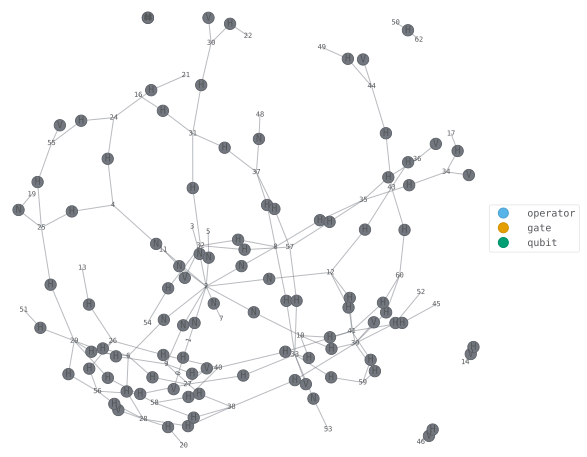

Tensor network visualization created!

TENSOR NETWORK DETAILS:

Tensor 1:
  Shape: (2,)
  Indices: ('0',)
  Tags: oset(['V'])
  Size in memory: 0.03 KB

Tensor 2:
  Shape: (2,)
  Indices: ('23',)
  Tags: oset(['V'])
  Size in memory: 0.03 KB

Tensor 3:
  Shape: (2,)
  Indices: ('27',)
  Tags: oset(['V'])
  Size in memory: 0.03 KB

Tensor 4:
  Shape: (2,)
  Indices: ('28',)
  Tags: oset(['V'])
  Size in memory: 0.03 KB

Tensor 5:
  Shape: (2,)
  Indices: ('30',)
  Tags: oset(['V'])
  Size in memory: 0.03 KB

Tensor 6:
  Shape: (2,)
  Indices: ('32',)
  Tags: oset(['V'])
  Size in memory: 0.03 KB

Tensor 7:
  Shape: (2,)
  Indices: ('33',)
  Tags: oset(['V'])
  Size in memory: 0.03 KB

Tensor 8:
  Shape: (2,)
  Indices: ('34',)
  Tags: oset(['V'])
  Size in memory: 0.03 KB

Tensor 9:
  Shape: (2,)
  Indices: ('36',)
  Tags: oset(['V'])
  Size in memory: 0.03 KB

Tensor 10:
  Shape: (2,)
  Indices: ('39',)
  Tags: oset(['V'])
  Size in memory: 0.03 KB

Tensor 11:
  Shape: (2,)
  Indices: 

In [51]:
# Visualize the tensor network structure
if use_full_tensor:
    print("Drawing tensor network structure...")
    
    # Draw the tensor network
    # This shows how the tensors are connected
    try:
        fig = tensor_network.draw(
            color=['operator', 'gate', 'qubit'],  # Color by tags
            show_tags=True,                        # Show tensor tags
            show_inds='all',                       # Show all indices
            figsize=(14, 8),
            iterations=200,                        # Layout iterations
            k=0.5,                                 # Spring constant for layout
        )
        print("Tensor network visualization created!")
    except Exception as e:
        print(f"Could not draw network: {e}")
        print("Trying simplified visualization...")
        try:
            fig = tensor_network.draw(figsize=(12, 8))
        except Exception as e2:
            print(f"Simplified draw also failed: {e2}")
    
    # Print detailed information about the network
    print(f"\n{'='*60}")
    print("TENSOR NETWORK DETAILS:")
    print(f"{'='*60}")
    
    for i, tensor in enumerate(tensor_network.tensors):
        print(f"\nTensor {i+1}:")
        print(f"  Shape: {tensor.shape}")
        print(f"  Indices: {tensor.inds}")
        print(f"  Tags: {tensor.tags}")
        print(f"  Size in memory: {tensor.data.nbytes / 1024:.2f} KB")
    
    print(f"\n{'='*60}")
    print(f"Total network memory: {sum(t.data.nbytes for t in tensor_network.tensors) / (1024**2):.2f} MB")
    print(f"{'='*60}")

In [52]:
# Set up cotengra optimizer for efficient tensor network contraction
if use_full_tensor:
    print("\nSetting up Cotengra optimizer...")
    
    # Create an optimizer instance
    # HyperOptimizer will try multiple methods automatically
    optimizer = ctg.HyperOptimizer(
        methods=['greedy', 'kahypar'],  # Use multiple optimization methods
        max_repeats=64,                 # Number of optimization attempts
        max_time=20,                    # Maximum time in seconds
        minimize='flops',               # Minimize floating point operations
        progbar=True                    # Show progress bar
    )
    
    print(f"Optimizer configured successfully!")
    print(f"Will use greedy and kahypar methods for optimization")
    print(f"Max repeats: 64, Max time: 20 seconds")
    
    # Analyze the contraction complexity before optimization
    print(f"\nTensor network contraction analysis:")
    print(f"  Number of tensors to contract: {tensor_network.num_tensors}")
    print(f"  Number of unique indices: {tensor_network.num_indices}")
    
    # Get all indices and their types
    outer_inds = tensor_network.outer_inds()
    inner_inds = [ind for ind in tensor_network.ind_map.keys() if ind not in outer_inds]
    
    print(f"  Outer indices (inputs/outputs): {len(outer_inds)}")
    print(f"  Inner indices (to contract): {len(inner_inds)}")
    
    if tensor_network.num_tensors > 1:
        print("\n  Outer indices:", sorted(list(outer_inds))[:20])
        if len(outer_inds) > 20:
            print("    ...")
        print("  Inner indices:", sorted(inner_inds)[:20])
        if len(inner_inds) > 20:
            print("    ...")


Setting up Cotengra optimizer...
Optimizer configured successfully!
Will use greedy and kahypar methods for optimization
Max repeats: 64, Max time: 20 seconds

Tensor network contraction analysis:
  Number of tensors to contract: 95
  Number of unique indices: 63
  Outer indices (inputs/outputs): 26
  Inner indices (to contract): 37

  Outer indices: ['11', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '3', '45', '46', '47', '48', '49', '5', '50', '51']
    ...
  Inner indices: ['0', '1', '10', '12', '2', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37']
    ...


In [35]:
# Contract the tensor network and compute eigenvalues
if use_full_tensor:
    print("\n" + "="*60)
    print("CONTRACTING TENSOR NETWORK")
    print("="*60)
    
    # Contract all indices to get the final operator matrix
    # This uses the cotengra optimizer to find the best path
    print("\nFinding optimal contraction path with Cotengra...")
    
    try:
        # Get the outer indices (these should remain after contraction)
        output_indices = tensor_network.outer_inds()
        print(f"Output indices to preserve: {sorted(list(output_indices))}")
        
        # Contract the tensor network using cotengra optimization
        # For hyper-networks, we need to explicitly specify output_inds
        result = tensor_network.contract(all, optimize=optimizer, output_inds=output_indices)
        
        print(f"Contraction successful!")
        print(f"Result type: {type(result)}")
        
        # Extract the data from the result
        if hasattr(result, 'data'):
            result_data = result.data
        else:
            result_data = result
            
        print(f"Result data shape: {result_data.shape}")
        
        # The result should be the full operator matrix
        # Reshape to proper matrix form for eigenvalue computation
        total_qubits_tn = n_inputs
        matrix_size = 2 ** total_qubits_tn
        
        # Reshape to matrix form (input indices × output indices)
        final_matrix = result_data.reshape(matrix_size, matrix_size)
        
        print(f"\nFinal matrix shape: {final_matrix.shape}")
        print(f"Matrix size in memory: {final_matrix.nbytes / (1024**2):.2f} MB")
        
        # Compute eigenvalues
        print("\n" + "="*60)
        print("COMPUTING EIGENVALUES")
        print("="*60)
        
        eigenvalues = np.linalg.eigvals(final_matrix)
        
        print(f"\nNumber of eigenvalues: {len(eigenvalues)}")
        print(f"\nTop eigenvalues (sorted by magnitude):")
        sorted_eigs = eigenvalues[np.argsort(np.abs(eigenvalues))[::-1]]
        for i, eig in enumerate(sorted_eigs[:10]):
            print(f"  {i+1}: {eig:.6f} (|λ| = {np.abs(eig):.6f})")
        if len(eigenvalues) > 10:
            print(f"  ... and {len(eigenvalues) - 10} more")
        
        # Show statistics
        print(f"\nEigenvalue statistics:")
        print(f"  Max magnitude: {np.max(np.abs(eigenvalues)):.6f}")
        print(f"  Min magnitude: {np.min(np.abs(eigenvalues)):.6f}")
        print(f"  Mean magnitude: {np.mean(np.abs(eigenvalues)):.6f}")
        print(f"  Std deviation: {np.std(np.abs(eigenvalues)):.6f}")
        
    except Exception as e:
        print(f"Error during contraction or eigenvalue computation: {e}")
        import traceback
        traceback.print_exc()
        
else:
    print("Cannot compute eigenvalues - system too large or tensor network not created.")
    print("Please reduce problem size.")


CONTRACTING TENSOR NETWORK

Finding optimal contraction path with Cotengra...
Output indices to preserve: ['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '3', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '48', '49', '6', '7', '8', '9']


F=9.34 C=11.15 S=31.00 P=31.01: 100%|██████████| 64/64 [00:00<00:00, 242.51it/s]


Contraction successful!
Result type: <class 'quimb.tensor.tensor_core.Tensor'>
Result data shape: (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
Error during contraction or eigenvalue computation: cannot reshape array of size 2147483648 into shape (1024,1024)


Traceback (most recent call last):
  File "C:\Users\jakeu\AppData\Local\Temp\ipykernel_1772\4099235925.py", line 37, in <module>
    final_matrix = result_data.reshape(matrix_size, matrix_size)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: cannot reshape array of size 2147483648 into shape (1024,1024)


NameError: name 'eigenvalues' is not defined

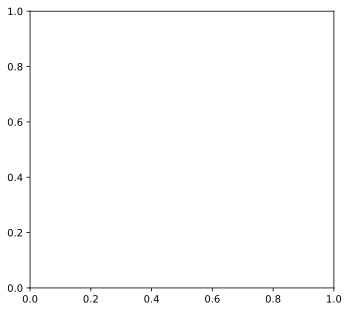

In [53]:
# Optional: Visualize eigenvalues
if use_full_tensor:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Eigenvalues in complex plane
    plt.subplot(1, 2, 1)
    plt.scatter(eigenvalues.real, eigenvalues.imag, alpha=0.6, s=50)
    plt.xlabel('Real part', fontsize=12)
    plt.ylabel('Imaginary part', fontsize=12)
    plt.title('Eigenvalues in Complex Plane', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linewidth=0.5)
    plt.axvline(x=0, color='k', linewidth=0.5)
    
    # Plot 2: Magnitude of eigenvalues
    plt.subplot(1, 2, 2)
    sorted_mags = np.sort(np.abs(eigenvalues))[::-1]
    plt.bar(range(len(sorted_mags)), sorted_mags, alpha=0.7, color='steelblue')
    plt.xlabel('Eigenvalue Index (sorted by magnitude)', fontsize=12)
    plt.ylabel('Magnitude', fontsize=12)
    plt.title('Eigenvalue Magnitudes', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.yscale('log')  # Use log scale to see small eigenvalues
    
    plt.tight_layout()
    plt.show()
else:
    print("Skipping visualization - no eigenvalues computed.")

In [54]:
# Diagnostic: Analyze the Hamiltonian structure
if use_full_tensor:
    print("="*60)
    print("HAMILTONIAN ANALYSIS")
    print("="*60)
    
    # Check if the matrix is Hermitian (should be for a physical Hamiltonian)
    is_hermitian = np.allclose(final_matrix, final_matrix.conj().T)
    print(f"\nIs matrix Hermitian? {is_hermitian}")
    
    if not is_hermitian:
        print("WARNING: Matrix is NOT Hermitian!")
        print("This could explain unexpected eigenvalue patterns.")
        print("\nMaking matrix Hermitian: H_eff = (H + H†)/2")
        hermitian_matrix = (final_matrix + final_matrix.conj().T) / 2
        
        # Recompute eigenvalues
        eigenvalues_hermitian = np.linalg.eigvalsh(hermitian_matrix)  # Use eigvalsh for Hermitian
        
        print(f"\nHermitian eigenvalues (all real):")
        sorted_eigs_herm = np.sort(eigenvalues_hermitian)[::-1]
        for i, eig in enumerate(sorted_eigs_herm[:10]):
            print(f"  {i+1}: {eig:.6f}")
        
        print(f"\nHermitian eigenvalue statistics:")
        print(f"  Max: {np.max(eigenvalues_hermitian):.6f}")
        print(f"  Min: {np.min(eigenvalues_hermitian):.6f}")
        print(f"  Mean: {np.mean(eigenvalues_hermitian):.6f}")
        print(f"  Std: {np.std(eigenvalues_hermitian):.6f}")
    
    # Check matrix properties
    print(f"\nMatrix properties:")
    print(f"  Norm (Frobenius): {np.linalg.norm(final_matrix):.6f}")
    print(f"  Trace: {np.trace(final_matrix):.6f}")
    print(f"  Determinant: {np.linalg.det(final_matrix):.6e}")
    
    # Check eigenvalue distribution
    print(f"\nEigenvalue distribution:")
    print(f"  Real part range: [{np.min(eigenvalues.real):.6f}, {np.max(eigenvalues.real):.6f}]")
    print(f"  Imag part range: [{np.min(eigenvalues.imag):.6f}, {np.max(eigenvalues.imag):.6f}]")
    
    # Count near-zero eigenvalues
    tol = 1e-10
    num_zero = np.sum(np.abs(eigenvalues) < tol)
    print(f"  Near-zero eigenvalues (|λ| < {tol}): {num_zero}")
    
    # Check for degeneracies
    unique_mags = np.unique(np.round(np.abs(eigenvalues), decimals=6))
    print(f"  Unique eigenvalue magnitudes: {len(unique_mags)} out of {len(eigenvalues)}")
    
    if len(unique_mags) < len(eigenvalues) / 2:
        print(f"  WARNING: High degeneracy detected! This suggests symmetry in the system.")

HAMILTONIAN ANALYSIS


NameError: name 'final_matrix' is not defined

## Expected Behavior for Random Pauli Hamiltonians

For a **truly random** sum of Pauli strings:
- The eigenvalues should follow a **Wigner semicircle** or **Gaussian** distribution (depending on the model)
- No special degeneracies (except accidental ones)
- Eigenvalues should be **real** (Hermitian operator)
- The W-state construction adds quantum superposition structure

**Possible reasons for patterns:**
1. **W-state structure**: The W-input/output adds specific entanglement
2. **Graph simplification**: ZX calculus reductions may create symmetries
3. **Small system size**: With few qubits, quantum effects dominate
4. **Phase correlations**: Random phases might accidentally align
5. **Non-Hermitian operator**: The construction might not preserve Hermiticity